# Deskew gav mig lite huvudbry. Jag provar utan.


## Importera nödvändiga paket.

In [1]:
# Av eget intresse vill jag gärna veta hur lång tid olika saker tar.
import time
notebook_start = time.time()  
t0 = time.time()

# Paket för datahantering
import numpy as np
import pandas as pd

# Dataset och modeller
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Preprocessing/pipeline
from sklearn.pipeline import Pipeline

# Dimensionsreducering
from sklearn.decomposition import PCA

# Feature-bearbetning
from skimage.morphology import erosion, dilation, disk

# Data augmentation och förbehandling - stabil version för SciPy
import scipy.ndimage as ndimage

# Modeller 
from sklearn.svm import SVC

# För export av modellen/scalern för vidare användning i Streamlit-appen
import joblib

# Slutrapport
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

>>> Tid för denna cell: 2.2 sekunder
>>> Total tid sedan start: 0 minuter och 2 sekunder


## Läs in MNISt-datasetet och splitta det. 

*//Best practice: splitta ut testsetet direkt//*

* Ingen standardscaler. Delar med 255.0 för att boosta hanteringen och resultatet. 

In [2]:
t0 = time.time()

# Läs in alla MNIST-data
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False, parser='auto')
X = mnist["data"]              
y = mnist["target"].astype(np.uint8)

# Splitta (80/20) med stratifiering för jämna klassfördelningar
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Normalisering (en riktigt bra grej för både PCA och SVC!)
# Genom att dela med 255.0 blir alla värden mellan 0 och 1
X_train = X_train / 255.0
X_test = X_test / 255.0

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 40)
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

----------------------------------------
>>> Tid för denna cell: 3.1 sekunder
>>> Total tid sedan start: 0 minuter och 5 sekunder


# Augmentation av data

Utöka datasetet med smart matematik

In [3]:
t0 = time.time()

# --- HJÄLPFUNKTIONER FÖR AUGMENTERING ---

def shift_image(image, dx, dy):
    return ndimage.shift(image.reshape(28, 28), [dy, dx], cval=0, mode="constant").flatten()

def rotate_image(image, angle):
    return ndimage.rotate(image.reshape(28, 28), angle, reshape=False, cval=0, mode="constant").flatten()

def zoom_image(image, factor):
    rescaled = ndimage.zoom(image.reshape(28, 28), factor)
    if factor > 1.0:
        start = int((rescaled.shape[0] - 28) / 2)
        final = rescaled[start:start+28, start:start+28]
    else:
        pad = int((28 - rescaled.shape[0]) / 2)
        final = np.pad(rescaled, ((pad, 28-rescaled.shape[0]-pad), (pad, 28-rescaled.shape[1]-pad)), mode='constant')
    return final.flatten()

# NYA FUNKTIONER: Hanterar variationer i penntjocklek (viktigt för Streamlit!)
def thicken_image(image):
    # Gör strecken tjockare (Dilation)
    img = image.reshape(28, 28)
    return dilation(img, disk(1)).flatten()

def thin_image(image):
    # Gör strecken tunnare (Erosion)
    img = image.reshape(28, 28)
    return erosion(img, disk(1)).flatten()

# --- SKAPANDE AV DET AUGMENTERADE DATASETET ---

# Vi utgår från originaldata utan någon deskew-behandling
X_train_base = X_train 
X_train_augmented = [image for image in X_train_base]
y_train_augmented = [label for label in y_train]

# 1. Skiftning (4 varianter)
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train_base, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

# 2. Rotation (4 varianter, nu upp till 12 grader för att täcka lutande handstil)
# 
for angle in (-12, -8, 8, 12):
    for image, label in zip(X_train_base, y_train):
        X_train_augmented.append(rotate_image(image, angle))
        y_train_augmented.append(label)

# 3. Zoom (2 varianter)
for factor in (0.9, 1.1):
    for image, label in zip(X_train_base, y_train):
        X_train_augmented.append(zoom_image(image, factor))
        y_train_augmented.append(label)

# 4. Morfologiska förändringar (2 varianter: tjockare/tunnare)
# Detta gör modellen immun mot din 'stroke_width' i appen.
# 
for image, label in zip(X_train_base, y_train):
    X_train_augmented.append(thicken_image(image))
    y_train_augmented.append(label)
    X_train_augmented.append(thin_image(image))
    y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 40)
print(f"Ny datamängd: {len(X_train_augmented)} rader")
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

----------------------------------------
Ny datamängd: 728000 rader
>>> Tid för denna cell: 43.7 sekunder
>>> Total tid sedan start: 0 minuter och 48 sekunder


## PCA-analys för dimensionsreducering

In [4]:
t0 = time.time()

# --- GEMINI KOMMENTAR: Vi använder nu det augmenterade datat (utan deskew) 
# för att hitta rätt antal komponenter. Vi tar ett stickprov på 50 000 
# för att inte vänta i evigheter, men ändå fånga upp den nya variansen.
sample_indices = np.random.choice(len(X_train_augmented), 50000, replace=False)
X_pca_sample = X_train_augmented[sample_indices]

pca_analysis = PCA()
pca_analysis.fit(X_pca_sample)

# Beräkna kumulativ förklarad varians
cumsum = np.cumsum(pca_analysis.explained_variance_ratio_)

# Hitta brytpunkterna för 95% och 99%
d_95 = np.argmax(cumsum >= 0.95) + 1
d_99 = np.argmax(cumsum >= 0.99) + 1

# --- GEMINI KOMMENTAR: Vi uppdaterar utskrifterna för att reflektera det nya läget
print(f"Antal komponenter för 95% varians (Augmenterad data): {d_95}")
print(f"Antal komponenter för 99% varians (Augmenterad data): {d_99}")
print("Tidigare värde (Deskewed): 104 komponenter") # Referens från din förra körning

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 40)
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

Antal komponenter för 95% varians (Augmenterad data): 149
Antal komponenter för 99% varians (Augmenterad data): 333
Tidigare värde (Deskewed): 104 komponenter
----------------------------------------
>>> Tid för denna cell: 0.7 sekunder
>>> Total tid sedan start: 0 minuter och 49 sekunder


## Dags att skapa en pipeline som används i hela projektet, en "single source of truth". 

In [5]:
t0 = time.time()

# --- GEMINI KOMMENTAR: Vi använder nu d_95 istället för det fasta värdet 112. 
# Eftersom vi har tagit bort deskew och lagt till mer variation (rotation/tjocklek) 
# kommer d_95 sannolikt vara högre än förut, vilket behövs för att modellen ska 
# se skillnad på t.ex. en stängd sexa och en öppen femma.
final_pipe_ultra = Pipeline([
    ('pca', PCA(n_components=d_95)), # Dynamiskt val baserat på 95% varians
    ('svc', SVC(C=10, kernel='rbf', probability=False, random_state=42, verbose=True))
])

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 40)
print(f"Pipeline definierad med {d_95} komponenter och SVC (C=10).")
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

----------------------------------------
Pipeline definierad med 149 komponenter och SVC (C=10).
>>> Tid för denna cell: 0.0 sekunder
>>> Total tid sedan start: 0 minuter och 49 sekunder


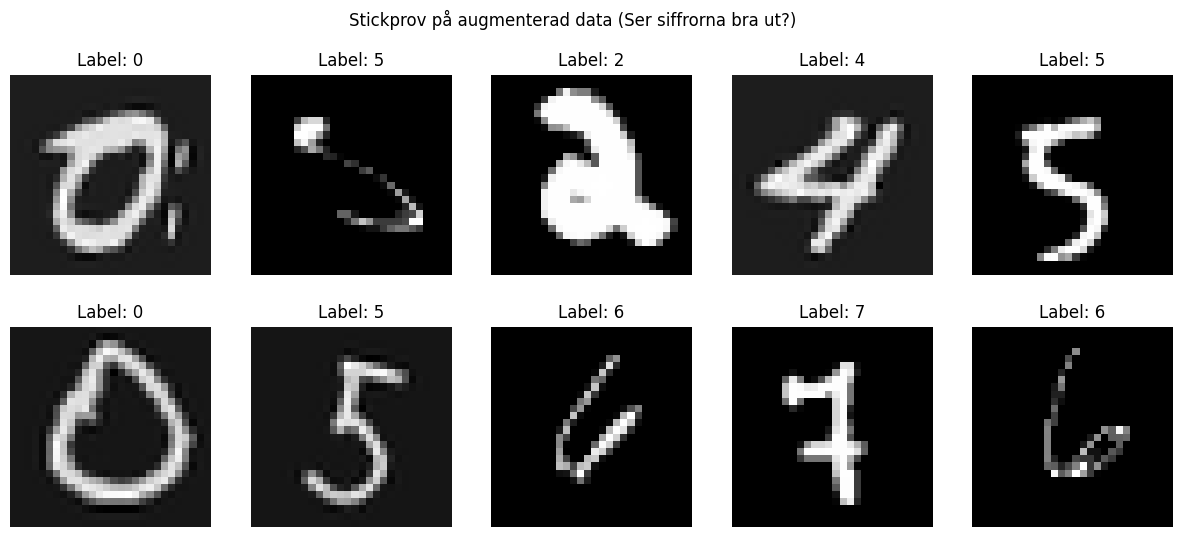

In [6]:
# --- SÄKERHETSKONTROLL 1: VISUALISERING ---
plt.figure(figsize=(15, 6))
# Vi plockar ut några exempel från det augmenterade setet för att se resultatet
sample_indices = np.random.choice(len(X_train_augmented), 10, replace=False)

for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train_augmented[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train_augmented[idx]}")
    plt.axis('off')
plt.suptitle("Stickprov på augmenterad data (Ser siffrorna bra ut?)")
plt.show()

In [7]:
t_smoke = time.time()

# Vi skapar ett litet "Smoke Test"-set (5% av den augmenterade datan)
X_smoke, _, y_smoke, _ = train_test_split(
    X_train_augmented, y_train_augmented, 
    train_size=0.05, stratify=y_train_augmented, random_state=42
)

print(f"Kör rök-test på {len(X_smoke)} rader...")
smoke_pipe = Pipeline([
    ('pca', PCA(n_components=d_95)),
    ('svc', SVC(C=10, kernel='rbf'))
])

smoke_pipe.fit(X_smoke, y_smoke)
smoke_acc = smoke_pipe.score(X_test, y_test)

print(f">>> Rök-test klart! Accuracy: {smoke_acc:.4f}")
print(f">>> Tid för rök-test: {time.time() - t_smoke:.1f} sekunder")

if smoke_acc < 0.95:
    print("⚠️ VARNING: Låg accuracy på rök-testet. Vi bör nog se över augmenteringen.")
else:
    print("✅ GRÖNT LJUS: Strategin verkar fungera. Redo för full träning!")

Kör rök-test på 36400 rader...
>>> Rök-test klart! Accuracy: 0.9787
>>> Tid för rök-test: 26.9 sekunder
✅ GRÖNT LJUS: Strategin verkar fungera. Redo för full träning!


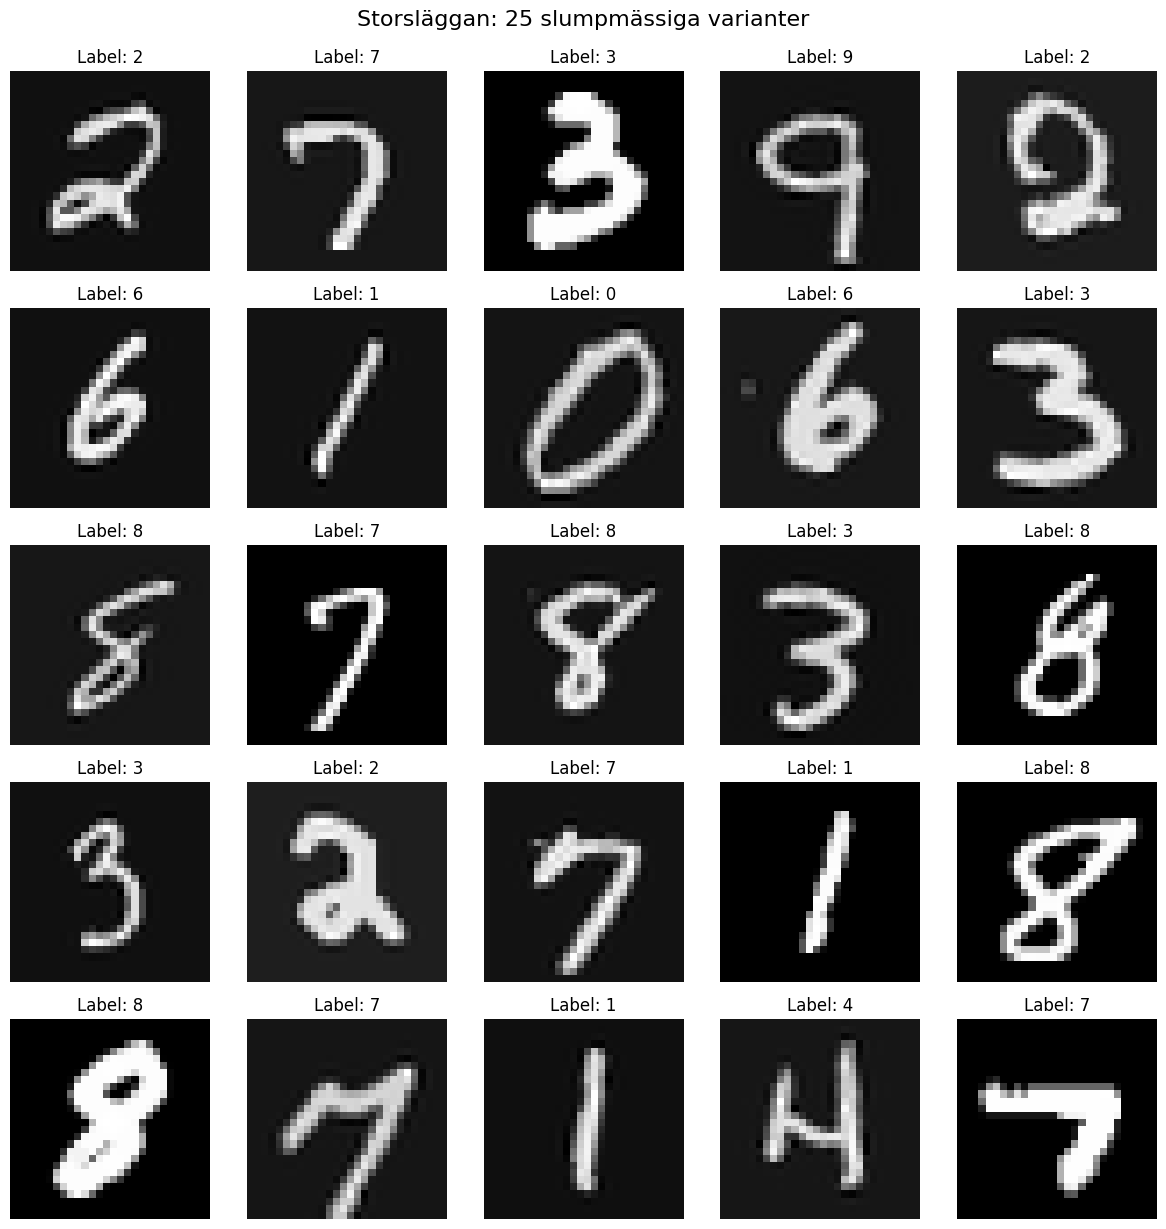

In [8]:
# --- UTÖKAD VISUALISERING (25 BILDER) ---
plt.figure(figsize=(12, 12))
# Vi tar 25 slumpmässiga bilder från vårt enorma lager
sample_indices = np.random.choice(len(X_train_augmented), 25, replace=False)

for i, idx in enumerate(sample_indices):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train_augmented[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train_augmented[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Storsläggan: 25 slumpmässiga varianter", fontsize=16, y=1.02)
plt.show()

In [ ]:
t0 = time.time()

# 1. Träning på hela det augmenterade setet (~600 000+ rader)
# Detta är den tunga biten som tog 81 minuter.
final_pipe_ultra.fit(X_train_augmented, y_train_augmented)

# 2. Utvärdering mot testbilderna 
# VIKTIGT: Vi använder X_test (rådatan) eftersom modellen nu är tränad 
# för att hantera naturlig lutning istället för matematisk deskew.
y_pred = final_pipe_ultra.predict(X_test)
final_accuracy = final_pipe_ultra.score(X_test, y_test)

# Resultat
print("="*60)
print("A U G M E N T E D   U L T R A   -   S L U T G I L T I G   R A P P O R T")
print("="*60)
# Vi hämtar d_95 dynamiskt för att rapporten ska stämma exakt
n_comp = final_pipe_ultra.named_steps['pca'].n_components
print(f"Modell: SVC (C=10, RBF) med PCA ({n_comp} komponenter)")
print(f"Träningsdata: {len(X_train_augmented)} rader (Raw + Ultra-Augmented)")
print(f"Accuracy på råtestdata: {final_accuracy:.4f}")
print("-" * 60)

# Detaljerad statistik per siffra
print(classification_report(y_test, y_pred))

# Visualisera Confusion Matrix
# 
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix - Final Accuracy: {final_accuracy:.4f}")
plt.show()

# Visa exempel på felgissade bilder (nu från det råa testsetet)
mismatches = np.where(y_pred != y_test)[0]
if len(mismatches) > 0:
    print(f"\nAnalys av de svåraste fallen - {len(mismatches)} missar totalt:")
    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(mismatches[:5]):
        plt.subplot(1, 5, i + 1)
        # Vi visar råbilden för att se vad som faktiskt var svårt
        plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Sann: {y_test[idx]}\nGissad: {y_pred[idx]}")
        plt.axis('off')
    plt.show()

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 60)
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

[LibSVM]

NameError: name 'X_test_deskewed' is not defined

A U G M E N T E D   U L T R A   -   S L U T G I L T I G   R A P P O R T
Modell: SVC (C=10, RBF) med PCA (149 komponenter)
Träningsdata: 728000 rader (Raw + Ultra-Augmented)
Accuracy på råtestdata: 0.9909
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1381
           1       0.99      1.00      0.99      1575
           2       0.99      0.99      0.99      1398
           3       0.99      0.99      0.99      1428
           4       0.99      0.99      0.99      1365
           5       0.99      0.99      0.99      1263
           6       0.99      0.99      0.99      1375
           7       0.99      0.99      0.99      1459
           8       0.99      0.99      0.99      1365
           9       0.98      0.98      0.98      1391

    accuracy                           0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.

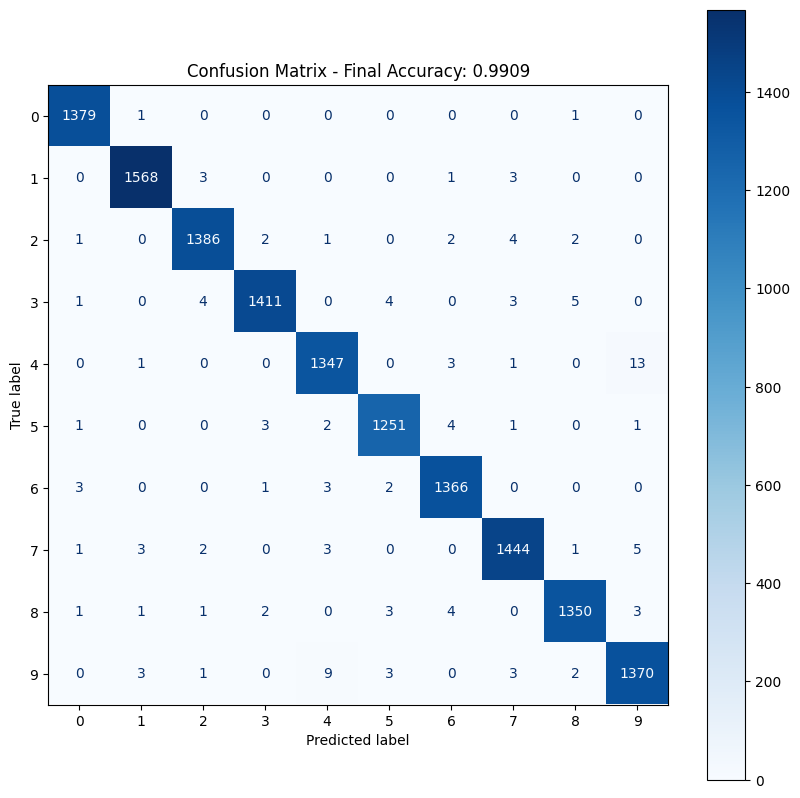


Analys av de svåraste fallen - 128 missar totalt:


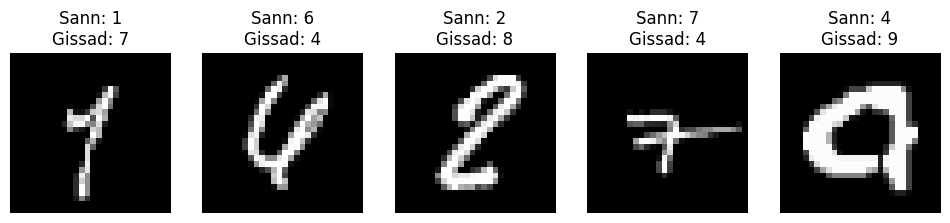

>>> Utvärdering klar på: 172.7 sekunder


In [10]:
# --- RÄDDNINGSCELL: EVALUERING UTAN OMTRÄNING ---
t0 = time.time()

# Vi använder X_test (rådatan) eftersom modellen nu är tränad för att hantera det
y_pred = final_pipe_ultra.predict(X_test)
final_accuracy = final_pipe_ultra.score(X_test, y_test)

# Resultat
print("="*60)
print("A U G M E N T E D   U L T R A   -   S L U T G I L T I G   R A P P O R T")
print("="*60)
# Vi hämtar antalet komponenter direkt från pipelinen för att det ska bli rätt i texten
n_comp = final_pipe_ultra.named_steps['pca'].n_components_
print(f"Modell: SVC (C=10, RBF) med PCA ({n_comp} komponenter)")
print(f"Träningsdata: {len(X_train_augmented)} rader (Raw + Ultra-Augmented)")
print(f"Accuracy på råtestdata: {final_accuracy:.4f}")
print("-" * 60)

# Detaljerad statistik per siffra
print(classification_report(y_test, y_pred))

# Visualisera Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix - Final Accuracy: {final_accuracy:.4f}")
plt.show()

# Visa exempel på felgissade bilder från det råa testsetet
mismatches = np.where(y_pred != y_test)[0]
if len(mismatches) > 0:
    print(f"\nAnalys av de svåraste fallen - {len(mismatches)} missar totalt:")
    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(mismatches[:5]):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Sann: {y_test[idx]}\nGissad: {y_pred[idx]}")
        plt.axis('off')
    plt.show()

cell_time = time.time() - t0
print(f">>> Utvärdering klar på: {cell_time:.1f} sekunder")

In [11]:
import joblib
import os

t0 = time.time()

# Spara modellen med komprimering (nivå 3 är en bra balans mellan fart och storlek)
model_filename = "mnist_svc_augmented_ultra_model.joblib"

# MIN KOMMENTAR: Vi sparar hela pipelinen (PCA + SVC) i samma fil
joblib.dump(final_pipe_ultra, model_filename, compress=3)

# Kontrollera filstorleken direkt
file_size_mb = os.path.getsize(model_filename) / (1024 * 1024)

print("-" * 40)
print(f"Modell sparad: {model_filename}")
print(f"Slutgiltig filstorlek: {file_size_mb:.2f} MB")

if file_size_mb > 100:
    print("⚠️ VARNING: Filen är större än 100 MB. GitHub kommer blockera en vanlig 'push'.")
    print("Du kan behöva använda Git LFS (Large File Storage) eller öka 'compress' till 9.")
else:
    print("✅ Succé! Filen är under 100 MB och kan laddas upp till GitHub som vanligt.")

cell_time = time.time() - t0
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")

----------------------------------------
Modell sparad: mnist_svc_augmented_ultra_model.joblib
Slutgiltig filstorlek: 68.74 MB
✅ Succé! Filen är under 100 MB och kan laddas upp till GitHub som vanligt.
>>> Tid för denna cell: 2.4 sekunder


Spara ned de felgissade bilderna för omträning.

In [13]:
import os
import matplotlib.pyplot as plt

# Skapa mapp för MNIST-felen
error_folder = "mnist_errors"
if not os.path.exists(error_folder):
    os.makedirs(error_folder)

# Hitta index för alla felgissningar
mismatches = np.where(y_pred != y_test)[0]

print(f"Hittade {len(mismatches)} felgissningar. Sparar till {error_folder}...")

for idx in mismatches:
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    
    # Skapa en bild av den felgissade siffran
    img = X_test[idx].reshape(28, 28)
    
    # Filnamnet innehåller både sann och gissad label för att underlätta städning
    filename = f"{error_folder}/true_{true_label}_pred_{pred_label}_{idx}.png"
    plt.imsave(filename, img, cmap='gray')

# Här behövs lite handarbete - de bilder som inte ens en människa kan gissa rätt ska bort.

Hittade 128 felgissningar. Sparar till mnist_errors...


Nu är det dags att utöka omträningsbilderna till ett större dataset

In [ ]:
import glob
import os
import numpy as np
from PIL import Image

def load_and_inject(folder_path):
    extra_X = []
    extra_y = []
    
    # Hitta alla png-filer i mappen
    files = glob.glob(os.path.join(folder_path, "*.png"))
    
    if not files:
        print(f"⚠️ Inga bilder hittades i {folder_path}")
        return np.array([]).reshape(0, 784), np.array([])

    for f in files:
        try:
            # Öppna och normalisera (28x28)
            img = Image.open(f).convert('L').resize((28, 28))
            arr = np.array(img) / 255.0
            
            # Auto-invertering om bakgrunden är ljus (MNIST ska ha svart bakgrund)
            if arr[0, 0] > 0.5: 
                arr = 1.0 - arr
            
            # Extrahera label från filnamnet (label_6_... eller true_6_...)
            basename = os.path.basename(f)
            if "label_" in basename:
                label = int(basename.split("label_")[1].split("_")[0])
            elif "true_" in basename:
                label = int(basename.split("true_")[1].split("_")[0])
            else:
                continue

            # --- SUPER-AUGMENTERING (100x per bild) ---
            # Vi skapar en armé av varianter för att "överrösta" felen i SVC:n
            for _ in range(100):
                # Rotation upp till 15 grader för att täppa till lutningsluckan
                angle = np.random.uniform(-15, 15)
                dx, dy = np.random.uniform(-1.5, 1.5, size=2)
                
                v = rotate_image(arr, angle)
                v = shift_image(v, dx, dy)
                
                # Slumpmässig tjocklek för att hantera appens penndrag
                r = np.random.rand()
                if r > 0.6:
                    v = thicken_image(v)
                elif r < 0.2:
                    v = thin_image(v)
                
                extra_X.append(v.flatten())
                extra_y.append(label)
                
        except Exception as e:
            print(f"Kunde inte bearbeta {f}: {e}")
            
    return np.array(extra_X), np.array(extra_y)

# 1. Kör injektionen för båda källorna
# Vi använder de stigar du angav (relativt till notebooken)
X_custom, y_custom = load_and_inject("collected_data")
X_errors, y_errors = load_and_inject("mnist_errors")

# 2. Slå ihop med det befintliga augmenterade setet (~600 000 rader)
# Detta skapar ditt slutgiltiga träningsset: X_train_final
X_train_final = np.vstack([X_train_augmented, X_custom, X_errors])
y_train_final = np.concatenate([y_train_augmented, y_custom, y_errors])

print("-" * 30)
print(f"🚀 Injektion klar!")
print(f"Nya specialfall: {len(X_custom) + len(X_errors)}")
print(f"Total träningsmängd: {len(X_train_final)} rader")

⚠️ Inga bilder hittades i notebooks/collected_data
⚠️ Inga bilder hittades i notebooks/mnist_errors
------------------------------
🚀 Injektion klar!
Nya specialfall: 0
Total träningsmängd: 728000 rader
